In [ ]:
# Google Drive and Colab are connected using this
gcolab = 1
if gcolab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import all required library
!pip install split-folders
import os
import shutil
import splitfolders
import numpy as np
import seaborn as sns
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import load_model
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
tf.random.set_seed(2023)

In [ ]:
# Make a directory that holds the complete dataset

os.mkdir("./Dataset Jenis Ikan/")
splitfolders.ratio("/content/drive/MyDrive/fishlab_dataset-2", output="./Dataset Jenis Ikan", seed=2023, ratio=(.80, 0.20), group_prefix=None)

Copying files: 1650 files [18:00,  1.53 files/s]


In [ ]:
output_folder = "./Dataset Jenis Ikan"

# Calculating the number of training data
train_folder = os.path.join(output_folder, "train")
num_train_samples = sum(len(files) for _, _, files in os.walk(train_folder))

# Calculating the number of validation data
val_folder = os.path.join(output_folder, "val")
num_val_samples = sum(len(files) for _, _, files in os.walk(val_folder))

# Showing the quantity of both training and validation data
print("The amount of training data:", num_train_samples)
print("The amount of validation data:", num_val_samples)


The amount of training data: 1320
The amount of validation data: 330


In [ ]:
# Make a directory containing the train's historical data so that it may be analyzed
splitfolders.ratio("./Dataset Jenis Ikan/train",
                   output="./Data Analisis Jenis Ikan",
                   seed=2023, ratio=(.80, .20),
                   group_prefix=None)

Copying files: 1320 files [00:01, 710.80 files/s]


In [ ]:
# Preprocessing Data: Images Augmentation
Training_dir = './Data Analisis Jenis Ikan/train'
train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.5, #0.2 >>> 1
                                   horizontal_flip=True,
                                   fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(Training_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))
Validation_dir = './Data Analisis Jenis Ikan/val'
validation_datagen = ImageDataGenerator(rescale = 1 / 255)

validation_generator = validation_datagen.flow_from_directory(Validation_dir,
                                                              batch_size=32, #berubah dari 32 ke 16
                                                              class_mode  = 'categorical',
                                                              target_size = (224, 224))

Found 1038 images belonging to 24 classes.
Found 282 images belonging to 24 classes.


In [ ]:
from keras.applications import MobileNetV2
# Using the MobileNetV2 model to create transfer learning model
pre_trained_model_ikan = MobileNetV2(input_shape=(224, 224, 3), #150 ke 224
                                     include_top=False,
                                     weights='imagenet')

# Set the pre-trained layer to be untrainable
for layer in pre_trained_model_ikan.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Create model
inputs = pre_trained_model_ikan.input
x = tf.keras.layers.Flatten()(pre_trained_model_ikan.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(24, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# Use adam optimizer and categorical_crossentropy to compile the model
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Establishing checkpoints to preserve the top models
sourcedata = "/content/drive/MyDrive/Percobaan_Analisis_Model_9"

# Prior to establishing the directory, make sure it doesn't already exist
if not os.path.exists(sourcedata):
    os.mkdir(sourcedata)

checkpoint = ModelCheckpoint(sourcedata, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Model Fit
start_time = time.time()
callbacks_list = [checkpoint]
history = model.fit(train_generator, validation_data=validation_generator,
                    steps_per_epoch=25, epochs=30, callbacks=[callbacks_list])

duration = time.time() - start_time
minutes = duration // 60
seconds = duration % 60
print("Run time : {:.0f}:{:.0f}".format(minutes, seconds))

Epoch 1/30
15/25 [=================>............] - ETA: 21s - loss: 2.6347 - accuracy: 0.3312

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 2.3393 - accuracy: 0.3811
Epoch 1: val_accuracy improved from -inf to 0.48582, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 107s 4s/step - loss: 2.3393 - accuracy: 0.3811 - val_loss: 3.1256 - val_accuracy: 0.4858
Epoch 2/30
 2/25 [=>............................] - ETA: 46s - loss: 1.2118 - accuracy: 0.6094 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 1.1594 - accuracy: 0.6496
Epoch 2: val_accuracy improved from 0.48582 to 0.70213, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 99s 4s/step - loss: 1.1594 - accuracy: 0.6496 - val_loss: 1.4031 - val_accuracy: 0.7021
Epoch 3/30
25/25 [==============================] - ETA: 0s - loss: 0.8733 - accuracy: 0.7563
Epoch 3: val_accuracy improved from 0.70213 to 0.73050, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 100s 4s/step - loss: 0.8733 - accuracy: 0.7563 - val_loss: 1.0494 - val_accuracy: 0.7305
Epoch 4/30
22/25 [=========================>....] - ETA: 8s - loss: 0.6771 - accuracy: 0.7930 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.7877
Epoch 4: val_accuracy did not improve from 0.73050
25/25 [==============================] - 85s 3s/step - loss: 0.6856 - accuracy: 0.7877 - val_loss: 0.9528 - val_accuracy: 0.7234
Epoch 5/30
25/25 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.8325
Epoch 5: val_accuracy improved from 0.73050 to 0.73759, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 97s 4s/step - loss: 0.5658 - accuracy: 0.8325 - val_loss: 0.8575 - val_accuracy: 0.7376
Epoch 6/30
 7/25 [=======>......................] - ETA: 44s - loss: 0.4537 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8517
Epoch 6: val_accuracy improved from 0.73759 to 0.76950, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 93s 4s/step - loss: 0.5056 - accuracy: 0.8517 - val_loss: 0.9176 - val_accuracy: 0.7695
Epoch 7/30
 5/25 [=====>........................] - ETA: 49s - loss: 0.5389 - accuracy: 0.8500

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.8849
Epoch 7: val_accuracy did not improve from 0.76950
25/25 [==============================] - 81s 3s/step - loss: 0.4344 - accuracy: 0.8849 - val_loss: 0.8247 - val_accuracy: 0.7695
Epoch 8/30
25/25 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8600
Epoch 8: val_accuracy improved from 0.76950 to 0.79787, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 101s 4s/step - loss: 0.4615 - accuracy: 0.8600 - val_loss: 0.7611 - val_accuracy: 0.7979
Epoch 9/30
 5/25 [=====>........................] - ETA: 50s - loss: 0.3907 - accuracy: 0.8813

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8926
Epoch 9: val_accuracy did not improve from 0.79787
25/25 [==============================] - 87s 3s/step - loss: 0.3542 - accuracy: 0.8926 - val_loss: 0.8253 - val_accuracy: 0.7447
Epoch 10/30
25/25 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.9015
Epoch 10: val_accuracy did not improve from 0.79787
25/25 [==============================] - 80s 3s/step - loss: 0.3318 - accuracy: 0.9015 - val_loss: 0.8022 - val_accuracy: 0.7943
Epoch 11/30
25/25 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.9156
Epoch 11: val_accuracy did not improve from 0.79787
25/25 [==============================] - 78s 3s/step - loss: 0.3227 - accuracy: 0.9156 - val_loss: 0.7698 - val_accuracy: 0.7943
Epoch 12/30
25/25 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.9182
Epoch 12: val_accuracy did not improve from 0.79787
25/25 [==============================]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9207
Epoch 18: val_accuracy did not improve from 0.80496
25/25 [==============================] - 77s 3s/step - loss: 0.2506 - accuracy: 0.9207 - val_loss: 0.8665 - val_accuracy: 0.7837
Epoch 19/30
25/25 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9300
Epoch 19: val_accuracy improved from 0.80496 to 0.81915, saving model to /content/drive/MyDrive/Percobaan_Analisis_Model_9
25/25 [==============================] - 94s 4s/step - loss: 0.2258 - accuracy: 0.9300 - val_loss: 0.7153 - val_accuracy: 0.8191
Epoch 20/30
 4/25 [===>..........................] - ETA: 35s - loss: 0.2361 - accuracy: 0.9182

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9425
Epoch 20: val_accuracy did not improve from 0.81915
25/25 [==============================] - 70s 3s/step - loss: 0.2119 - accuracy: 0.9425 - val_loss: 0.7773 - val_accuracy: 0.7801
Epoch 21/30
25/25 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9271
Epoch 21: val_accuracy did not improve from 0.81915
25/25 [==============================] - 71s 3s/step - loss: 0.2215 - accuracy: 0.9271 - val_loss: 0.7647 - val_accuracy: 0.8014
Epoch 22/30
25/25 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9476
Epoch 22: val_accuracy did not improve from 0.81915
25/25 [==============================] - 78s 3s/step - loss: 0.2109 - accuracy: 0.9476 - val_loss: 0.8255 - val_accuracy: 0.7872
Epoch 23/30
25/25 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9373
Epoch 23: val_accuracy did not improve from 0.81915
25/25 [==============================

Text(0.5, 1.0, 'Training and validation loss')

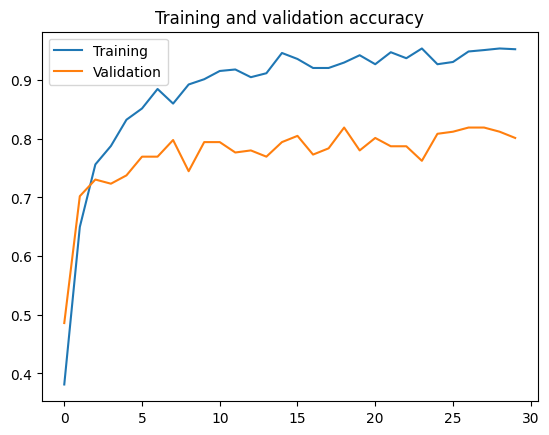

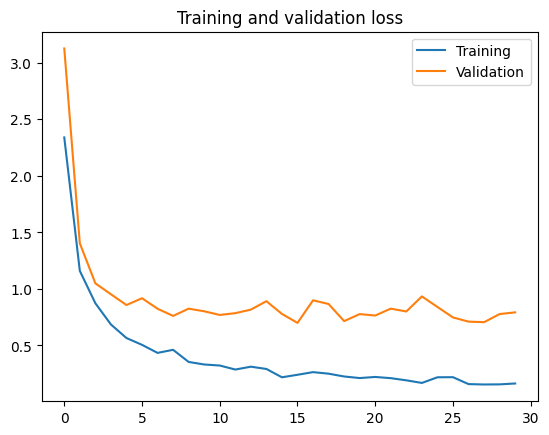

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss'   )

In [ ]:
# Saved the model to H5 format
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# H5 model convertion to tflite format
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Jika Anda ingin menyimpan model TFLite dengan kuantisasi (misalnya, kuantisasi pasca-latih atau kuantisasi saat latihan), Anda dapat menyesuaikan konverter sesuai dengan kebutuhan Anda. Contoh kuantisasi pasca-latih:

python
Copy code
converter.optimizations = [tf.lite.Optimize.DEFAULT]
Jangan lupa untuk menggantikan nama model dan file output sesuai dengan kebutuhan dan preferensi Anda.

In [ ]:
model_json = model.to_json()
with open("model.json","w") as file:
  file.write(model_json)

In [ ]:
model.save_weights("weights.h5")